### Toxic Comment Classification

### Using Bidirectional GRU (LB=0.96630)

Biredirectional GRU has been used:
1) Bidirectional is used beacuse in case sentence needs to have more weightage on the successor word than previous words.<br>
2) GRU's are faster to train as LSTM's.

In [1]:
#importing librarie
%matplotlib inline
import pandas as pd
import numpy as np
#warnings
import warnings
warnings.filterwarnings('ignore')
#visulaisation
import  seaborn as sns
import matplotlib.pyplot as plt
#nlp
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
#keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import RNN, GRU, LSTM, Dense, Input, Embedding, Dropout, Activation, concatenate
from keras.layers import Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [2]:
'''importing the dataframes'''
X_train = pd.read_pickle('X_train.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')

In [3]:
print("X_train shape:",X_train.shape)
print("X_test shape:",X_test.shape)
print("Train Labels shape:",y_train.shape)

X_train shape: (159571, 2)
X_test shape: (153164, 2)
Train Labels shape: (159571, 6)


In [4]:
print("X_train columns",list(X_train.columns))
print("X_test columns",list(X_test.columns))
print("y_train columns",list(y_train.columns))

X_train columns ['id', 'comments']
X_test columns ['id', 'comments']
y_train columns ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [3]:
train = X_train["comments"].str.lower() #lowering the text
test = X_test["comments"].str.lower()

In [4]:
'''seeting the parameters'''
max_features = 159571
max_len = 150     #max length of our vectors
embed_size = 50  #embed size used in the embedding layers

In [ ]:
'''tokenize the data and assign numerical values to it.'''
tokenizer = Tokenizer(max_features)
tokenizer.fit_on_texts(list(train))

In [ ]:
tokenized_train_sentences = tokenizer.texts_to_sequences(train) #train is tokenised
tokenized_test_sentences = tokenizer.texts_to_sequences(test)

In [9]:
'''output of the train[1] tokenised data'''
tokenized_train_sentences[1]

[449, 13749, 142, 945, 459, 2233, 1, 3730, 818, 66, 7, 864, 124]

In [10]:
train[1]

'd aww he match background colour i seemingly stick thanks talk january utc'

In [ ]:
'''padding is done to ensure the text are of same length to be fed into rnns'''
train = pad_sequences(tokenized_train_sentences, max_len) 
test = pad_sequences(tokenized_test_sentences, max_len)

### TFIDF-weighted W2Vec

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(ngram_range=(1,2),min_df=3, max_df=0.9,use_idf=1,
               smooth_idf=1, sublinear_tf=1)

In [ ]:
train = tf.fit_transform(X_train['comments'])

In [18]:
list_of_sent = []
for sentence in X_train['comments']:
    try:
        list_of_sent.append(sentence.split())
    except:
        print(sentence)
len(list_of_sent)

159571

In [ ]:
'''buiding our own corpus on the dataset of dim=50'''
from gensim.models import Word2Vec
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [ ]:
'''below function computes the tfidf weighted word2vec for the whole dataset'''
def gen_tfidf_w2v(model,list_of_sent,w2v_model,dictionary):
    tfidf_feat = model.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sent): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                try:
                    vec = w2v_model.wv[word]
        #           tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                    # to reduce the computation we are 
                    # dictionary[word] = idf value of word in whole courpus
                    # sent.count(word) = tf valeus of word in this review
                    tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                    sent_vec += (vec * tf_idf)
                    weight_sum += tf_idf
                except:
                    pass
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

In [ ]:
dictionary = dict(zip(tf.get_feature_names(), list(tf.idf_)))

In [22]:
emb = gen_tfidf_w2v(tf,list_of_sent,w2v_model,dictionary) 

100%|██████████| 159571/159571 [14:28<00:00, 183.80it/s]


In [ ]:
#list to array conversion
emb = np.array(emb)

### GRU architecture

In [ ]:
'''Bidirectional GRU architecture'''
image_input = Input(shape=(max_len, ))
x = Embedding(max_features, embed_size,weights=[emb])(image_input) #tfidf weighted w2vec has been used as weights
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))(x)
x = GlobalMaxPooling1D()(x)
x = Dense(30, activation="relu",kernel_initializer='he_normal')(x)
x = Dropout(0.2)(x)
x = Dense(6, activation="sigmoid")(x)  #sigmoid has been used to have probability values sum>1.eg.0.99+0.92....
model = Model(inputs=image_input, outputs=x)

In [ ]:
from keras.optimizers import Adam
model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy'])

In [ ]:
'''callbacks are used to tune the learning rate and save the best weights'''
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
filepath="gru.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss',save_best_only=True, verbose=1)
reduce_on_plateau = ReduceLROnPlateau(monitor="val_loss", mode="min", factor=0.1, patience=4, verbose=1)
early_stopping = EarlyStopping( monitor='val_loss',patience=8,verbose=1,restore_best_weights=True)
callbacks_list = [checkpoint, reduce_on_plateau, early_stopping]

In [ ]:
classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = y_train[classes].values

In [41]:
'''model training stoped on the 10th epoch because the val loss was not improving after changing the learning rate  '''
history= model.fit(train, y, batch_size=512, epochs=15, validation_split=0.2,
          callbacks=callbacks_list,verbose=1,use_multiprocessing=True)

Train on 127656 samples, validate on 31915 samples
Epoch 1/15
127656/127656 [==============================] - 219s 2ms/step - loss: 0.0922 - accuracy: 0.9712 - val_loss: 0.0535 - val_accuracy: 0.9806

Epoch 00001: val_loss improved from inf to 0.05355, saving model to /content/drive/My Drive/Models/gru.h5
Epoch 2/15
127656/127656 [==============================] - 218s 2ms/step - loss: 0.0507 - accuracy: 0.9814 - val_loss: 0.0492 - val_accuracy: 0.9822

Epoch 00002: val_loss improved from 0.05355 to 0.04921, saving model to /content/drive/My Drive/Models/gru.h5
Epoch 3/15
127656/127656 [==============================] - 214s 2ms/step - loss: 0.0436 - accuracy: 0.9834 - val_loss: 0.0494 - val_accuracy: 0.9820

Epoch 00003: val_loss did not improve from 0.04921
Epoch 4/15
127656/127656 [==============================] - 215s 2ms/step - loss: 0.0395 - accuracy: 0.9846 - val_loss: 0.0504 - val_accuracy: 0.9808

Epoch 00004: val_loss did not improve from 0.04921
Epoch 5/15
127656/127656 [=

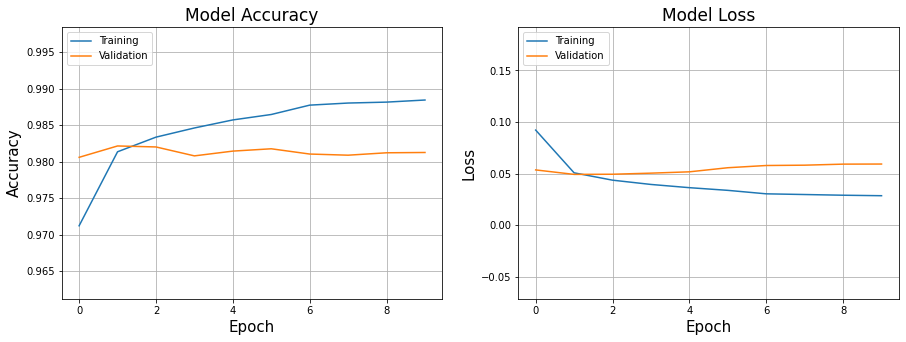

In [42]:
# plotting the accuracy vs loss with the number of Epochs
xlabel = 'Epoch'
legends = ['Training', 'Validation']

ylim_pad = [0.01, 0.1]

plt.figure(figsize=(15, 5))

# Plot training & validation Accuracy values

y1 = history.history['accuracy']
y2 = history.history['val_accuracy']

min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]


plt.subplot(121)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Accuracy', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()

                         
# Plot training & validation loss values
    
y1 = history.history['loss']
y2 = history.history['val_loss']

min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]
    
    
plt.subplot(122)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Loss', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()
                         
plt.show()

In [10]:
# load weights
model.load_weights('gru.h5')

In [44]:
test_values = model.predict([test], batch_size=512, verbose=1)

153164/153164 [==============================] - 18s 117us/step


In [45]:
test_values

array([[9.98926342e-01, 3.99175525e-01, 9.52660263e-01, 5.36454469e-02,
        8.50376964e-01, 1.33892789e-01],
       [2.11148965e-03, 4.10062484e-07, 1.22926940e-04, 5.78091067e-06,
        1.03589540e-04, 1.94857803e-05],
       [8.21999181e-03, 1.83710586e-06, 4.17403091e-04, 2.37292588e-05,
        4.74881643e-04, 6.61713057e-05],
       ...,
       [1.20011915e-04, 1.70126775e-08, 7.83933592e-06, 1.95624025e-07,
        3.50104460e-06, 8.37679863e-07],
       [1.75215222e-03, 1.57472812e-07, 6.31249131e-05, 2.23155689e-06,
        6.29910573e-05, 1.01557789e-05],
       [7.83040822e-01, 8.42854567e-03, 4.81861472e-01, 6.55162754e-03,
        2.88468689e-01, 1.86139122e-02]], dtype=float32)

In [7]:
pred_cols=['toxic','severe_toxic','obscene','threat','insult','identity_hate']
pred_df = pd.DataFrame(test_values,columns=pred_cols)

In [ ]:
idd =X_test['id']
sub = pd.concat([idd,pred_df],axis=1)
sub.to_csv('gru_sub.csv',index=False)